In [1]:
import pandas as pd
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
import matplotlib.image as mpimg

/usr/share/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
def load_specific_faces(folder,im_names,size):
    faces = np.zeros([size,224,224,3])
    for i in range(size):
        img = mpimg.imread('{}/{}'.format(folder,im_names[i]))
        faces[i,:,:] = img
#         if(i%100==0):
#             print("done with {} images".format(i))
    return faces

def process_faces(faces):
    l = faces.shape[0]
    processed_faces = np.zeros([l,224,224,3])
    for i in range(l):
        x = np.expand_dims(faces[i], axis = 0)
        x = preprocess_input(x)
        processed_faces[i,:,:] = x
        if(i%100==0):
            print("done with {} images".format(i))
    return processed_faces

## Here's the Plan

- load in "leftover" data
- augment POC faces, train on those + balanced unaugmented white faces
- validate on non augmented faces(?)

In [6]:
# load in metadata
adience_leftovers = pd.read_csv('adience_leftovers.csv')
new_path = ['{}.jpg'.format(i) for i in adience_leftovers.index.values]
adience_leftovers['new_path'] = new_path
adience_leftovers.dropna(how='any')
adience_leftovers.reset_index(inplace=True)

In [7]:
# find POC
poc_df = adience_leftovers[adience_leftovers.race != 'White']
black = poc_df[poc_df.race == 'African']
asian = poc_df[poc_df.race == 'Asian']
white = adience_leftovers[adience_leftovers.race =='White']
black[black.gender_y == 'm'].shape

(58, 18)

In [8]:
# there are only 58 black men in the set (smallest group)
# we want to make 4 augmented variations of each face
# so we will have 232 total faces in each subgroup
# but the white faces will not be augmented

# create the df with the necessary subgroup sizes

black_male = black[black.gender_y =='m']
black_female = black[black.gender_y == 'f'].sample(n = 58, random_state=42,axis=0)
asian_male = asian[asian.gender_y =='m'].sample(n = 58, random_state=42,axis=0)
asian_female = asian[asian.gender_y =='f'].sample(n = 58, random_state=42,axis=0)
white_male = white[white.gender_y =='m'].sample(n = 232, random_state=42,axis=0)
white_female = white[white.gender_y =='f'].sample(n = 232, random_state=42,axis=0)

In [9]:
# RUN ONLY ONCE!
poc_to_be_augmented = black_male.append(black_female)
poc_to_be_augmented = poc_to_be_augmented.append(asian_male)
poc_to_be_augmented = poc_to_be_augmented.append(asian_female)

In [10]:
white_faces = white_male.append(white_female)

In [11]:
# Next: load the images to be augmented
# augment and store them as arrays
# adjust length of gender_y accordingly
# load white faces, store as arrays
# append the two things together to create training set
# train using model_2v2

In [12]:
# adjust length of gender_y accordingly
y_poc = [i for i in poc_to_be_augmented.gender_y.values for count in range(4)]

In [13]:
# IMGAUG CODE
import imgaug as ia
from imgaug import augmenters as iaa

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
#         iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
#             cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 2),
            [
#                 sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
#                     iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, .5), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
#                 iaa.SimplexNoiseAlpha(iaa.OneOf([
#                     iaa.EdgeDetect(alpha=(0.5, 1.0)),
#                     iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
#                 ])),
#                 iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.1),
                ]),
#                 iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
#                 iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
#                 iaa.OneOf([
#                     iaa.Multiply((0.5, 1.5), per_channel=0.5),
#                     iaa.FrequencyNoiseAlpha(
#                         exponent=(-4, 0),
#                         first=iaa.Multiply((0.5, 1.5), per_channel=True),
#                         second=iaa.ContrastNormalization((0.5, 2.0))
#                     )
#                 ]),
#                 iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
#                 iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
#                 sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)


In [14]:
poc_paths = poc_to_be_augmented.new_path.values
l = len(poc_paths)
num_augs = 4

images = load_specific_faces('adience_leftovers',poc_paths,l)
augmented_poc = np.zeros([l*4,224,224,3])

counter = -1
for i in range(l):
    for num in range(num_augs):
        if(counter%100 == 0):
            print("done with {} images".format(counter))
        counter += 1
        img_aug = seq.augment_images([images[i]])
        augmented_poc[counter,:,:] = img_aug[0]


done with 0 images
done with 100 images
done with 200 images
done with 300 images
done with 400 images
done with 500 images
done with 600 images
done with 700 images
done with 800 images
done with 900 images


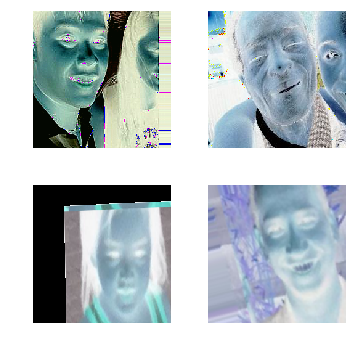

In [15]:
# plot a few augmented images just to see 'em
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(2, 2, figsize = (5, 5))
for i in range(2):
    for j in range(2):
        ax[i,j].set_axis_off()
        ax[i,j].imshow(augmented_poc[np.random.randint(0,931)])

plt.tight_layout()
plt.show()

In [16]:
# pretty dramatic, but let's just see how it goes

In [17]:
# now that we have our augmented images, we need to process them in order to feed to the neural net
x_poc = process_faces(augmented_poc)

#also dont forget white faces:
white_paths = white_faces.new_path.values
x_white = load_specific_faces('adience_leftovers',white_paths,len(white_paths))
x_white = process_faces(x_white)

done with 0 images
done with 100 images
done with 200 images
done with 300 images
done with 400 images
done with 500 images
done with 600 images
done with 700 images
done with 800 images
done with 900 images
done with 0 images
done with 100 images
done with 200 images
done with 300 images
done with 400 images


In [18]:
# append the two arrays
x_train = np.concatenate((x_poc,x_white))

In [19]:
# append the outputs
y_white = white_faces.gender_y.values
y_train = np.concatenate((y_poc,y_white))

In [21]:
# one hot encode output
from keras.utils import to_categorical
y_train = to_categorical(pd.Series(list(y_train)).map({'f':0,'m':1}),num_classes=2)
x_train.shape, y_train.shape

((1392, 224, 224, 3), (1392, 2))

In [23]:
# create validation set

val_set = poc_to_be_augmented.append(white_faces)

val_paths = val_set.new_path.values
x_val = load_specific_faces('adience_leftovers',val_paths,len(val_paths))
x_val = process_faces(x_val)

y_val = val_set.gender_y
y_val = to_categorical(y_val.map({'f':0,'m':1}),num_classes=2)

done with 0 images
done with 100 images
done with 200 images
done with 300 images
done with 400 images
done with 500 images
done with 600 images


In [24]:
# load model 2v2
from keras.models import load_model

model = load_model('mfs_model_2v2.h5')

In [25]:
# train it!
history = model.fit(x_train,y_train,batch_size=128,epochs=25,verbose=1,
        validation_data=(x_val, y_val))

Train on 1392 samples, validate on 696 samples
Epoch 1/25
1392/1392 [==============================] - 97s 69ms/step - loss: 0.9040 - acc: 0.5873 - val_loss: 0.6687 - val_acc: 0.5805
Epoch 2/25
1392/1392 [==============================] - 96s 69ms/step - loss: 0.6454 - acc: 0.6268 - val_loss: 0.6196 - val_acc: 0.6487
Epoch 3/25
1392/1392 [==============================] - 96s 69ms/step - loss: 0.6247 - acc: 0.6523 - val_loss: 0.6488 - val_acc: 0.6027
Epoch 4/25
1392/1392 [==============================] - 96s 69ms/step - loss: 0.6112 - acc: 0.6577 - val_loss: 0.5624 - val_acc: 0.7019
Epoch 5/25
1392/1392 [==============================] - 96s 69ms/step - loss: 0.5788 - acc: 0.6965 - val_loss: 0.5405 - val_acc: 0.7457
Epoch 6/25
1392/1392 [==============================] - 96s 69ms/step - loss: 0.5268 - acc: 0.7277 - val_loss: 0.4741 - val_acc: 0.7737
Epoch 7/25
1392/1392 [==============================] - 96s 69ms/step - loss: 0.5028 - acc: 0.7464 - val_loss: 0.4731 - val_acc: 0.7644
E

In [26]:
# save the model
model.save_weights('mfs_weights_4.h5')
model.save('mfs_model_4.h5')

In [27]:
# This is looking suspiciously good. Maybe we are overfitting
# because the validation set is the unaugmented version of the training images.
# Let's create a val_set2 that is a random sample of the leftout adience data 
# (and therefore more white faces??) and see how the model does with that.
# then we can compare accuracy on predictions.

new_model = load_model('mfs_model_2v2.h5')

In [28]:
# what the heck, let's also make the validation set the same size as the training.
# it will take longe but might be worth it.

val_set2 = adience_leftovers.sample(n=1392,random_state=42,axis=0)

val_paths2 = val_set2.new_path.values
x_val2 = load_specific_faces('adience_leftovers',val_paths2,len(val_paths2))
x_val2 = process_faces(x_val2)

y_val2 = val_set2.gender_y
y_val2 = to_categorical(y_val2.map({'f':0,'m':1}),num_classes=2)

done with 0 images
done with 100 images
done with 200 images
done with 300 images
done with 400 images
done with 500 images
done with 600 images
done with 700 images
done with 800 images
done with 900 images
done with 1000 images
done with 1100 images
done with 1200 images
done with 1300 images


In [29]:
# let's see how it performs now

history2 = new_model.fit(x_train,y_train,batch_size=128,epochs=25,verbose=1,
        validation_data=(x_val2, y_val2))

Train on 1392 samples, validate on 1392 samples
Epoch 1/25
1392/1392 [==============================] - 110s 79ms/step - loss: 0.9529 - acc: 0.5740 - val_loss: 0.6620 - val_acc: 0.6519
Epoch 2/25
1392/1392 [==============================] - 110s 79ms/step - loss: 0.6659 - acc: 0.5891 - val_loss: 0.6199 - val_acc: 0.6595
Epoch 3/25
1392/1392 [==============================] - 110s 79ms/step - loss: 0.6424 - acc: 0.6293 - val_loss: 0.5996 - val_acc: 0.6624
Epoch 4/25
1392/1392 [==============================] - 110s 79ms/step - loss: 0.5874 - acc: 0.6756 - val_loss: 0.5971 - val_acc: 0.6810
Epoch 5/25
1392/1392 [==============================] - 111s 79ms/step - loss: 0.5632 - acc: 0.7130 - val_loss: 0.5677 - val_acc: 0.7004
Epoch 6/25
1392/1392 [==============================] - 111s 79ms/step - loss: 0.5347 - acc: 0.7284 - val_loss: 0.5942 - val_acc: 0.6800
Epoch 7/25
1392/1392 [==============================] - 110s 79ms/step - loss: 0.4911 - acc: 0.7611 - val_loss: 0.5901 - val_acc: 

In [72]:
new_model.save_weights('mfs_weights_5.h5')
new_model.save('mfs_model_5.h5')

In [39]:
from sklearn.externals import joblib
# joblib.dump(history.history, 'history1.pkl') 

['history1.pkl']

In [40]:
# joblib.dump(history2.history, 'history2.pkl')

['history2.pkl']

In [43]:
his1 = joblib.load('history1.pkl')
his2 = joblib.load('history2.pkl')

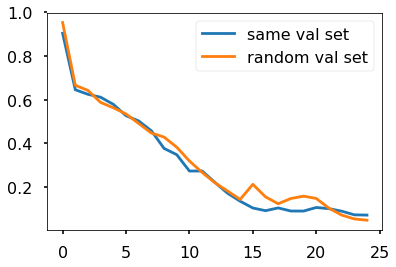

In [44]:
import seaborn as sns
sns.set_context()
plt.plot(his1['loss'],label="same val set")
plt.plot(his2['loss'],label="random val set")
plt.legend()

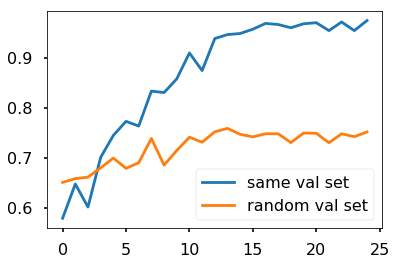

In [45]:
plt.plot(his1['val_acc'],label="same val set")
plt.plot(his2['val_acc'],label="random val set")
plt.legend()

In [67]:
# create a test set
leave_out = val_set2.index.values
test_set = adience_leftovers[~adience_leftovers['index'].isin(leave_out)]

In [70]:
test_paths = test_set.new_path.values
x_test = load_specific_faces('adience_leftovers',test_paths,len(test_paths))
x_test = process_faces(x_test)

y_test = test_set.gender_y
y_test = to_categorical(y_test.map({'f':0,'m':1}),num_classes=2)

done with 0 images
done with 100 images
done with 200 images
done with 300 images
done with 400 images
done with 500 images
done with 600 images
done with 700 images
done with 800 images
done with 900 images
done with 1000 images
done with 1100 images
done with 1200 images
done with 1300 images
done with 1400 images
done with 1500 images
done with 1600 images
done with 1700 images
done with 1800 images
done with 1900 images
done with 2000 images
done with 2100 images
done with 2200 images
done with 2300 images
done with 2400 images
done with 2500 images
done with 2600 images
done with 2700 images
done with 2800 images
done with 2900 images
done with 3000 images
done with 3100 images
done with 3200 images
done with 3300 images
done with 3400 images
done with 3500 images
done with 3600 images
done with 3700 images
done with 3800 images
done with 3900 images
done with 4000 images
done with 4100 images
done with 4200 images
done with 4300 images
done with 4400 images
done with 4500 images


In [71]:
# trained with augmented data, validated on same data but not augmented 
# (val_acc = .97)
model.evaluate(x_test,y_test)

14849/14849 [==============================] - 297s 20ms/step


[1.3991180655430266, 0.7206545895346488]

In [73]:
# trained with augmented data, validated on random sample from adience_leftovers
new_model.evaluate(x_test,y_test)

14849/14849 [==============================] - 297s 20ms/step


[1.2963674800373006, 0.7447302848676679]

In [74]:
# new model doesn't have a val_acc higher than old model, but lets see prediction accuracy!
# old_model is from before augmented data
old_model = load_model('mfs_model_2v2.h5')
old_model.evaluate(x_test,y_test)

14849/14849 [==============================] - 292s 20ms/step


[1.5099456022785878, 0.7170853256111522]

In [ ]:
# cool, the newest model does the best.